# Vorticity Streamfunction Equations (Cont.)
#### Hunter Lybbert
#### Student ID 2426454
#### 11-22-24

In [5]:
from typing import Optional

import numpy as np
from scipy.integrate import solve_ivp
from scipy.sparse import spdiags, dia_matrix
from matplotlib import pyplot as plt

### This section is from HW 04
Helpful references are in the textbook, [Data-Driven Modeling & Scientific Computation](https://faculty.washington.edu/kutz/kutz_book_v2.pdf) by J. Nathan Kutz,  on pages 209 and 221.

In [6]:
def partial_in_x(n: int) -> dia_matrix:
    """
    :param n: the dimension of the (n, n) matrix
    """
    upper = np.ones(n*n)
    lower = -1*np.ones(n*n)

    matrix = spdiags([upper, lower, lower, upper], diags=np.array([n, -n, n*(n - 1), -n*(n - 1)]))

    return matrix


def partial_in_y(n: int) -> dia_matrix:
    """
    :param n: the dimension of the (n, n) matrix
    """
    upper = np.tile(np.repeat([0, 1], [1, n-1]), n)
    lower = np.tile(np.repeat([-1, 0], [n-1, 1]), n)

    upper_wrap_around = np.tile(np.repeat([0, -1], [n-1, 1]), n)
    lower_wrap_around = np.tile(np.repeat([1, 0], [1, n-1]), n)

    matrix = spdiags([upper, lower, upper_wrap_around, lower_wrap_around], diags=np.array([1, -1, n - 1, -n + 1]))

    return matrix


def second_gradient_x_y(n: int) -> dia_matrix:
    """
    :param n: the dimension of the (n, n) matrix
    """
    main_diag = -4*np.ones(n*n)
    upper = np.tile(np.repeat([0, 1], [1, n-1]), n)
    lower = np.tile(np.repeat([1, 0], [n-1, 1]), n)
    
    upper_wrap_around = np.tile(np.repeat([0, 1], [n-1, 1]), n)
    lower_wrap_around = np.tile(np.repeat([1, 0], [1, n-1]), n)

    off_diag = np.ones(n*n)

    data = [
        main_diag,
        upper,
        lower,
        upper_wrap_around,
        lower_wrap_around,
        off_diag,
        off_diag,
        off_diag,
        off_diag
    ]
    diags = np.array(
        [
            0,
            1,
            -1,
            n - 1,
            -n + 1,
            n*(n - 1),
            -n*(n - 1),
            n,
            -n
        ]
    )

    matrix = spdiags(data, diags=diags)

    return matrix


def build_matrices(
    n: int,
    delta_x: float,
    delta_y: Optional[float] = None,
    output_as_np: Optional[bool] = False
) -> np.array:
    """
    
    :param n: the dimension of the (n,n) matrices
    :param delta_x: the step size in x
    :param delta_y: the step size in y
    :param output_as_np: 

    """
    if not delta_y:
        delta_y = delta_x

    if delta_x == delta_y:
        A = (1/(delta_x**2))*second_gradient_x_y(n)
        B = (1/(2*delta_x))*partial_in_x(n)
        C = (1/(2*delta_x))*partial_in_y(n)

    else:
        raise NotImplementedError("Currently do not support different step sizes in x and y")
    
    if output_as_np:
        A = A.toarray()
        B = B.toarray()
        C = C.toarray()

    return A, B, C

In [7]:
def prob1(L, n) -> tuple[np.array]:
    """
    :param L: the upper bound on the range (-L,L) to solve the diff eq on
    :param n: the number of intervals to chop up out 2 spatial dimensions
    """
    delta_x = (L - (-L)) / n

    return build_matrices(n, delta_x=delta_x, output_as_np=True)

A1, A2, A3 = prob1(L=10, n=8)

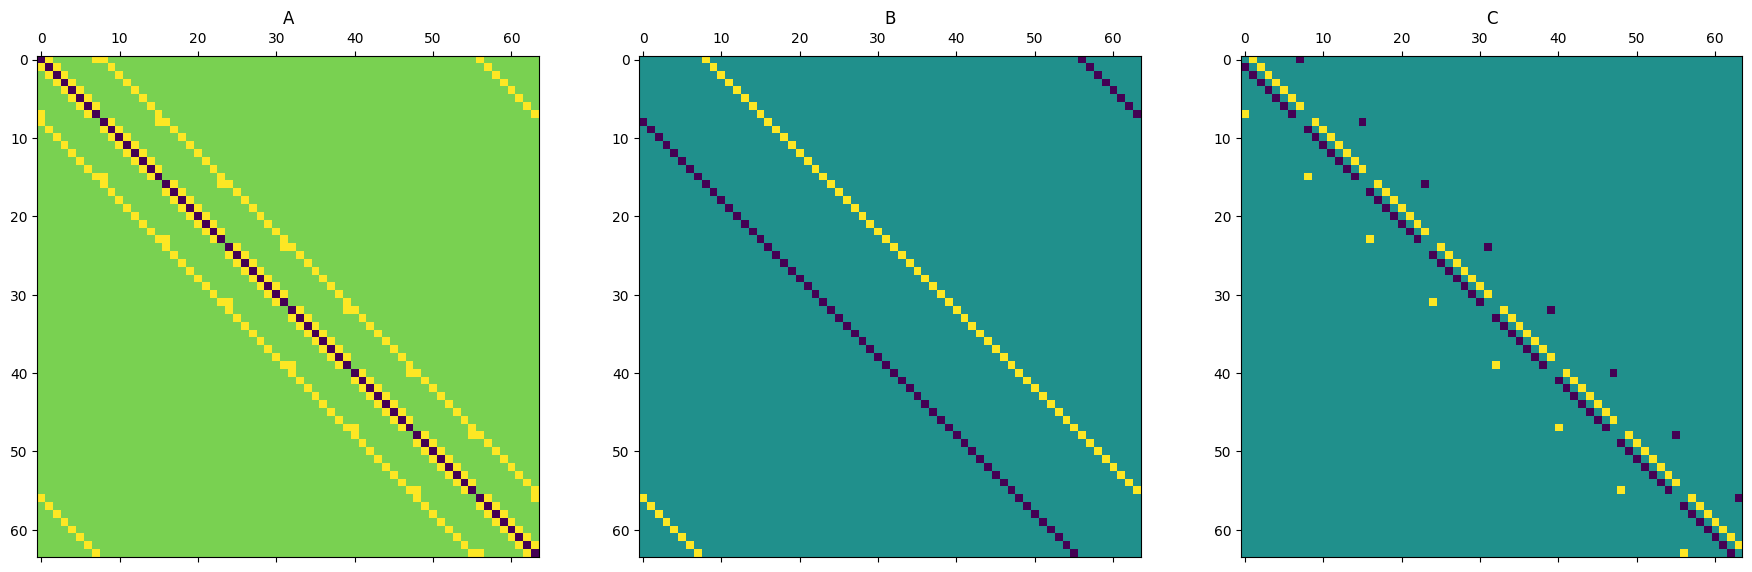

In [8]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(22)
fig.set_figheight(10)


ax[0].matshow(A1, cmap='viridis')
ax[0].set_title("A")
ax[1].matshow(A2, cmap='viridis')
ax[1].set_title("B")
ax[2].matshow(A3, cmap='viridis')
ax[2].set_title("C")
plt.show()

### Now we begin HW 5

#### A little pseudo code and math latex helpful stuff

set $\omega^t = \omega^0$

`For t in time:`

1) Solve $$A\psi^t = \omega^t$$
2) Time step update $$\omega^{t+1} = \omega^t + \Delta t \left[ \nu A\omega^t - \left( B\psi^t C\omega^t - C\psi^tB\omega^t \right) \right]$$

In [9]:
def omega_0(
    x: np.array,
    y: np.array,
    amplitude: float = 1,
    variance_in_x: float = 4,
    variance_in_y: float = 1,
) -> np.array:
    """
    Initial conditions for vorticity aka omega.

    :param x: the array indicating the linspace in the x spatial dimenstino
    :param y: the array indicating the linspace in the y spatial dimenstino
    :param amplitude: the height of the gaussian at x,y = (0,0)
    :param variance_in_x: measure of the spread of the gaussian in the x direction
    :param variance_in_y: measure of the spread of the gaussian in the y direction

    """
    exponent = (
        -x**2/variance_in_x
        -y**2/variance_in_y
    )
    return amplitude*np.exp(exponent)

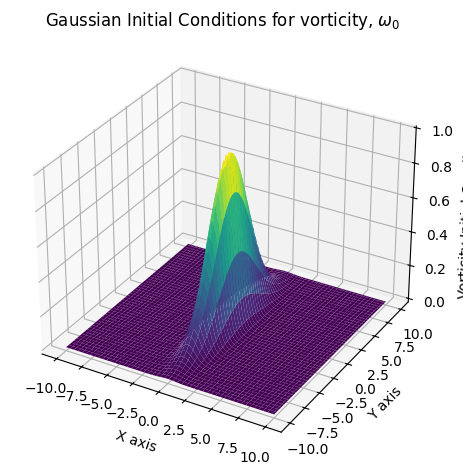

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def plot_initial_vorticity(
    L: int,
    omega_0: callable,
    omega_kwargs: Optional[dict[str, float]] = {}
) -> None:
    """
    :param L: the upperboound on the dimension for x and y (-L,L)
    :param omega_0: the initial condition function
    :param omega_kwargs: import kwargs to pass along to the omega initial condition function 

    :returns: None
    """
    # Create a grid of x and y values
    x = np.linspace(-L, L, 100)
    y = np.linspace(-L, L, 100)
    X, Y = np.meshgrid(x, y)

    # Compute the Gaussian values on the grid
    Z = omega_0(X, Y, **omega_kwargs)

    # Plotting in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')

    # Set plot labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Vorticity Initial Conditions')
    ax.set_title(r'Gaussian Initial Conditions for vorticity, $\omega_0$')
    # ax.set_box_aspect(aspect=None, zoom=0.8)
    plt.tight_layout()
    plt.savefig("images/image01.png")
    plt.show()

plot_initial_vorticity(L=10, omega_0=omega_0, omega_kwargs={"variance_in_x": 1, "variance_in_y": 20})

General questions to determine...

1) Am I supposed to only use the difference matrices from HW 4 when I am using the various methods of solving the linear systems (i.e. LU, A/b, etc.)?
2) When I am doing the fourier version, am I only using fourier to solve the grad^2 \psi term or am I using it to solve for each of the terms in the omega time ode?
    - Definitely impliment the stuff on page 212 for this one
    - use the derivative matrices...I think for the second stuff
3) more...

In [ ]:
from typing import Any
from enum import Enum
from scipy.fftpack import fft2, ifft2

def fourier_solve(
    omega: np.array,
    kx: np.array,
    ky: np.array,
) -> np.array:
    """This should be an nxn array in and out"""
    derivative_terms = kx**2 + ky**2
    omega_ft = -fft2(omega)/derivative_terms

    psi = ifft2(omega_ft)
    return psi


class LinearSystemSolveMethods(Enum):
    """
    Options of how to solve system
    """
    fourier = "fourier"
    basic_ab = "basic_ab"
    lu_decomp = "lu_decomp"
    bicgstab = "BICGSTAB"
    gmres = "GMRES"


# TODO Maybe rework this into a class...
class VorticityStreamFunctionSolver:
    """A clase to configure and solve the Vorticity Stream Function Differential Equation."""
    
    def __init__(self, nu: float, L: int, n: float) -> None:
        """
        Initialize Everything.
        
        :param nu: customizable parameter, no clear interpretation yet

        :returns: None
        """
        self.L: int = L
        self.n: float = n
        self.nu: float = nu

        self._setup_omega_0()
        self._setup_diff_matrices()
        self._setup_wavenumbers()

    def _setup_omega_0(self) -> None:
        """"""
        x_full = np.linspace(-self.L, self.L, self.n + 1)
        y_full = np.linspace(-self.L, self.L, self.n + 1)

        x_trunc = x_full[:n]

        self.X, self.Y = np.meshgrid(x_full, y_full)
        omega_0_mat: np.array = omega_0(
            x=self.X,
            y=self.Y,
            variance_in_x=1,
            variance_in_y=20,  # this is provided from the assignment
        )
        omega_0_vec: np.array = omega_0_mat.reshape(self.n*self.n)
        self.omega_0 = omega_0_vec

    def _setup_diff_matrices(self) -> None:
        delta_x = ( self.L - (-self.L))/self.n
        self.A, self.B, self.C = build_matrices(n=self.n, delta_x=delta_x)

    def _setup_wavenumbers(self) -> None:
        """
        """
        scale_factor = 2 * np.pi / (self.L - (-self.L))
        kx = scale_factor * np.concatenate((np.arange(0, self.n/2), np.arange(-self.n/2, 0)))
        ky = scale_factor * np.concatenate((np.arange(0, self.n/2), np.arange(-self.n/2, 0)))

        # avoid divide by zero with floating point precision error
        kx[0] = 1e-6
        ky[0] = 1e-6
        self.kx, self.ky = np.meshgrid(kx, ky)
    
    def omega_ode_rhs(self, t: float, omega: np.array):
        """Define the ODE."""
        omega_mat = omega.reshape((self.n, self.n))
        
        psi_mat = fourier_solve(omega_mat, kx=self.kx, ky=self.ky)  # expand this in the future for other linear solvers
        psi = psi_mat.reshape(self.n*self.n)

        diffusion = self.nu * self.A@omega
        advection = ((self.B@psi) @ (self.C@omega)) - ((self.C@psi) @ (self.B@omega))
        final = diffusion - advection

        return final
    
    def solve(self, t_span: tuple[int, int]) -> None:
        """Solve the ODE with solve_ivp."""
        self.omega_sol = solve_ivp(
            self.omega_ode_rhs,
            t_span=t_span,
            y0=self.omega_0
        )
        return self.omega_sol
    
    def prepare_attributes_for_plotting(self) -> None:
        """Mostly reshape omega res"""
        pass

    def create_animation(self,):
        """Create animation of the system as time evolved."""
        # be sure to remember how to embed the animations so it can be run on github
        pass


def solve_vorticity_streamfunction(
    plot: bool = True,
    animate: bool = True,
) -> None:
    """
    Solve the system

    :returns: None
    """
    # setup...
    L = 10
    n = 8
    nu = 0.001  # as given in the assignment

    VSFSolver = VorticityStreamFunctionSolver(nu=nu, L=L, n=n)
    result = VSFSolver.solve(t_span=(0, 4))

    if plot or animate:
        VSFSolver.create_animation()

    return result

solve_vorticity_streamfunction(plot=False, animate=False)

ValueError: cannot reshape array of size 81 into shape (64,)

In [14]:
A1 = None
A2 = None
A3 = None

In [ ]:
def get_linear_system_solve_callable(
    solve_method: LinearSystemSolveMethods
) -> np.array:
    """
    solve_method
    """
    if solve_method.value == LinearSystemSolveMethods.fourier.value:
        return fourier_solve

    else:
        raise NotImplementedError(f"We have not yet implimented the {solve_method.value}.")